In [219]:
from __future__ import annotations

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import csv
from dataclasses import dataclass

import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt

from coin_ai.fg_segmentation import SegmentationDino

In [220]:
@dataclass
class Homography:
    path1: str
    path2: str
    H: np.ndarray

    @property
    def image1(self) -> np.ndarray:
        return imageio.imread(self.path1)
    
    @property
    def image2(self) -> np.ndarray:
        return imageio.imread(self.path2)
    
    def inverse(self) -> Homography:
        return Homography(self.path2, self.path1, np.linalg.inv(self.H))


def parse_homography_csv(source_path: str) -> list[Homography]:
    HEADERS = ['img1', 'h11', 'h12', 'h13', 'h21', 'h22', 'h23', 'h31', 'h32', 'h33']

    if not os.path.exists(source_path):
        raise ValueError(f'File {source_path} does not exist')

    pairs = []
    with open(source_path, 'r') as f:
        reader = csv.reader(f)
        headers = next(reader)
        assert headers[:len(HEADERS)] == HEADERS
        for img1, img2, *floats in reader:
            H_floats = floats[:9]
            source_dir = os.path.dirname(source_path)
            path1 = os.path.join(source_dir, img1)
            path2 = os.path.join(source_dir, img2)
            pairs.append(Homography(
                path1, path2, np.array(H_floats, dtype=np.float32).reshape(3, 3)
            ))
    
    return pairs

In [221]:
def compute_correspondences(h: int, w: int, H: np.ndarray, scale: float = 1.0) -> np.ndarray:
    # Generate a grid of coordinates (x, y) for each pixel in the first image
    y, x = np.indices((h, w)) * scale
    coords = np.stack((x.ravel(), y.ravel(), np.ones_like(x).ravel()), axis=-1)

    # Apply the homography matrix to the coordinates
    # This transforms coordinates from the first image to the second image
    transformed_coords = H.dot(coords.T).T

    # Normalize the coordinates
    transformed_coords /= transformed_coords[:, 2][:, np.newaxis]

    # Reshape the transformed coordinates back to the image shape and keep only x, y
    correspondences = transformed_coords[:, :2].reshape(h, w, 2)

    correspondences /= scale

    return correspondences

In [222]:
def warp_image(image: np.ndarray, correspondences: np.ndarray) -> np.ndarray:
    correspondences = correspondences.astype(int)

    xs, ys = correspondences[:, :, 0], correspondences[:, :, 1]
    h, w, c = image.shape
    in_bounds_mask = (xs >= 0) & (xs < w) & (ys >= 0) & (ys < h)

    warped_image = np.zeros_like(image)
    warped_image[ys[in_bounds_mask], xs[in_bounds_mask]] = image[in_bounds_mask]#[ys[in_bounds_mask], xs[in_bounds_mask]]

    return warped_image


In [223]:
pairs = parse_homography_csv('/Users/jatentaki/Data/archeo/coins/cropped-with-background/Krzywousty/Typ 3/Awers - stempel a.07/homographies.csv')

/var/folders/xg/xwkfrrcs2rg2sc_hrv6ztr5r0000gn/T/ipykernel_42676/2550286736.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(self.path1)
/var/folders/xg/xwkfrrcs2rg2sc_hrv6ztr5r0000gn/T/ipykernel_42676/2550286736.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(self.path2)


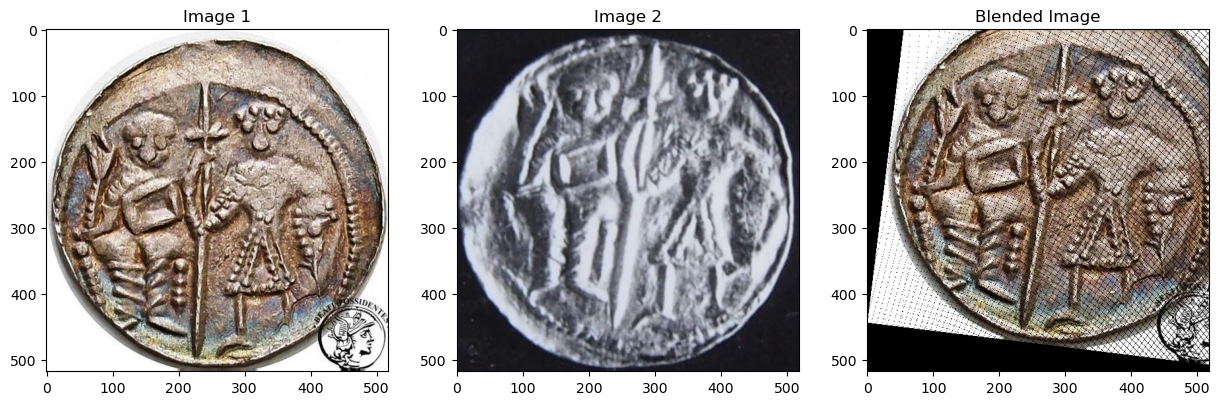

In [224]:
pair = pairs[0]
image1 = pair.image1
image2 = pair.image2

h, w = image1.shape[:2]

# Create a new image by warping the first image using the computed correspondences
correspondences = compute_correspondences(h, w, pair.H)
warped_image = warp_image(image1, correspondences)

# Create a new image by warping the second image using the inverse of the computed homography
H_inv = np.linalg.inv(pair.H)
correspondences_inv = compute_correspondences(h, w, H_inv)
warped_image_inv = warp_image(image2, correspondences_inv)

# Create a new image by blending the two warped images
blended_image = cv2.addWeighted(warped_image, 0.5, image2, 0.5, 0)

# Plot the original images and the blended image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image1)
ax[0].set_title('Image 1')
ax[1].imshow(image2)
ax[1].set_title('Image 2')
ax[2].imshow(warped_image)
ax[2].set_title('Blended Image')
plt.show()

In [225]:
import torch
from einops import rearrange
from torch import nn, Tensor
from torchvision.transforms import v2 as transforms
from kornia.utils import image_to_tensor

device = torch.device('mps')
dino = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_reg").to(device)

def get_embeddings(images: Tensor | np.ndarray) -> Tensor:
    if isinstance(images, np.ndarray):
        images = image_to_tensor(images.copy(), keepdim=False)
    else:
        images = images.clone()
    
    if images.dtype == torch.uint8:
        images = transforms.ToDtype(torch.float32)(images)
    
    images = transforms.Grayscale(num_output_channels=3)(images)

    b, c, h, w = images.shape
    assert (h, w) == (518, 518)
    with torch.no_grad():
        images = images.to(device)
        tokens = dino.forward_features(images)
        patch_tokens = tokens['x_norm_patchtokens']
    return rearrange(patch_tokens, 'b (h w) c -> b h w c', h=37, w=37)

Using cache found in /Users/jatentaki/.cache/torch/hub/facebookresearch_dinov2_main


In [226]:
sd = SegmentationDino()
mask = sd.segment(torch.from_numpy(image1).permute(2, 0, 1).unsqueeze(0))

Using cache found in /Users/jatentaki/.cache/torch/hub/facebookresearch_dinov2_main


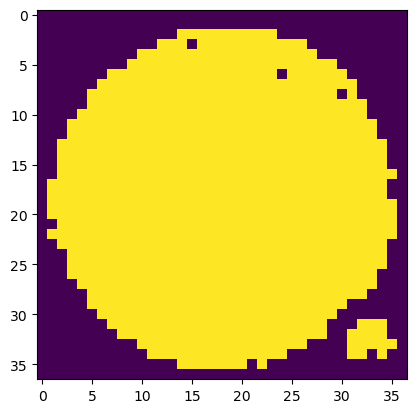

In [227]:
plt.imshow(mask.squeeze(0))

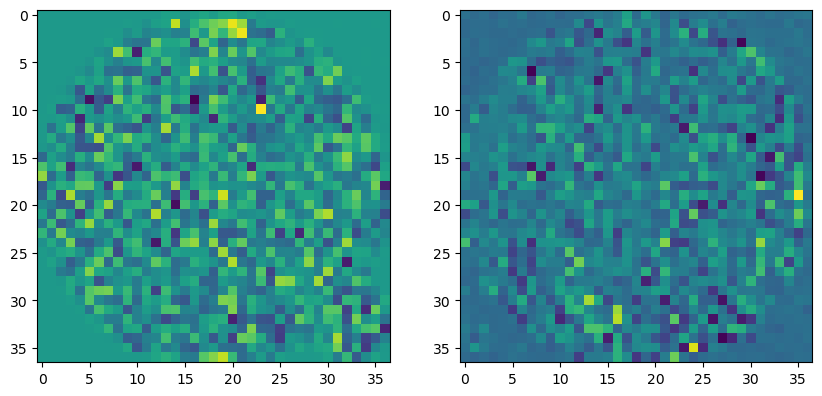

In [228]:
embeddings1 = get_embeddings(image1)
embeddings2 = get_embeddings(image2)

fig, (a1, a2) = plt.subplots(1, 2, figsize=(10, 5))
a1.imshow(embeddings1[0, ..., 0].cpu().numpy())
a2.imshow(embeddings2[0, ..., 0].cpu().numpy())

In [229]:
import torch.nn.functional as F

def _loss_fn(a: Tensor, b: Tensor, corr: Tensor, margin: float = 0.5) -> Tensor:
    similarity = F.cosine_similarity(a[:, None], b[None, :], dim=-1)
    a_ix, b_ix = corr.unbind(dim=-1)
    positive = similarity[a_ix, b_ix].unsqueeze(-1)
    negative = similarity[a_ix]
    return F.relu(margin - positive + negative).mean()

@dataclass
class MatchingPatches:
    left: Tensor
    right: Tensor
    corr_lr: Tensor
    corr_rl: Tensor

    def __repr__(self) -> str:
        return f'MatchingPatches(left={self.left.shape}, right={self.right.shape}, corr_lr={self.corr_lr.shape}, corr_rl={self.corr_rl.shape})'

    def loss(self, embed_fn: nn.Module) -> Tensor:
        left = embed_fn(self.left.flatten(0, -2))
        right = embed_fn(self.right.flatten(0, -2))

        loss_lr = _loss_fn(left, right, self.corr_lr)
        return loss_lr
        #loss_rl = _loss_fn(right, left, self.corr_rl)
        #return loss_lr + loss_rl
    
    def to(self, device: torch.device) -> MatchingPatches:
        return MatchingPatches(
            self.left.to(device),
            self.right.to(device),
            self.corr_lr.to(device),
            self.corr_rl.to(device),
        )

def match_patches(image1: np.ndarray, image2: np.ndarray, H: np.ndarray) -> MatchingPatches:
    features1 = get_embeddings(image1).squeeze(0)
    features2 = get_embeddings(image2).squeeze(0)

    left_fg_mask = sd.segment(image1).squeeze(0)
    right_fg_mask = sd.segment(image2).squeeze(0)

    left_fg_mask = left_fg_mask.flatten()
    right_fg_mask = right_fg_mask.flatten()

    left_fg_mask = torch.ones_like(left_fg_mask)
    right_fg_mask = torch.ones_like(right_fg_mask)

    h, w = features1.shape[0:2]

    corr_lr = torch.from_numpy(compute_correspondences(h, w, np.linalg.inv(H), scale=14)).to(torch.int64)
    corr_rl = torch.from_numpy(compute_correspondences(h, w, H, scale=14)).to(torch.int64)

    fig, (a1, a2) = plt.subplots(1, 2)
    a1.imshow(corr_lr[..., 0].float() / 37 - 0.5, cmap='seismic')
    a2.imshow(corr_lr[..., 1].float() / 37 - 0.5, cmap='seismic')

    is_in_bounds = lambda xy: (xy >= 0).all(dim=-1) & (xy < 37).all(dim=-1)
    left_in_bounds = is_in_bounds(corr_lr)
    right_in_bounds = is_in_bounds(corr_rl)

    corr_warp = corr_lr.clone()
    corr_warp[~left_in_bounds] = 0
    low_res1 = rearrange(image1, '(h i) (w j) c -> h w (i j) c', i=14, j=14).mean(axis=-2) / 255
    warped = torch.from_numpy(low_res1)[corr_warp[..., 1], corr_warp[..., 0]]
    plt.figure()
    plt.imshow(warped)
    plt.show()

    flatten_xy = lambda xy: (xy[..., 0] * 37 + xy[..., 1]).flatten()
    corr_lr = flatten_xy(corr_lr)
    corr_rl = flatten_xy(corr_rl)
    left_in_bounds = left_in_bounds.flatten()
    right_in_bounds = right_in_bounds.flatten()

    left_mask = left_in_bounds & right_fg_mask
    left_mask &= (corr_lr > 20 * 37) & (corr_lr < 21 * 37) | ((corr_lr % 37 == 20) & (corr_lr // 37 > 15) & (corr_lr // 37 < 20))
    #left_mask |= (corr_lr % 37 == 10)
    right_mask = right_in_bounds & left_fg_mask

    grid = torch.arange(37 * 37).reshape(37, 37).T.flatten()
    corr_lr = torch.stack([corr_lr, grid], dim=-1)
    corr_rl = torch.stack([corr_rl, grid], dim=-1)

    #print(corr_lr[left_mask].amax())

    return MatchingPatches(
        features1,
        features2,
        corr_lr[left_mask],
        corr_rl[right_mask],
    )

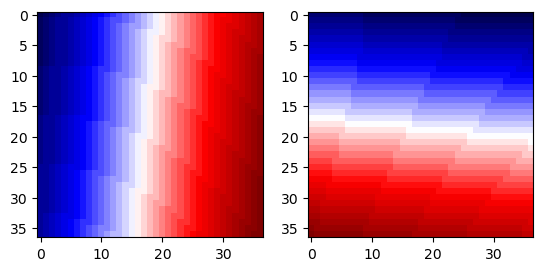

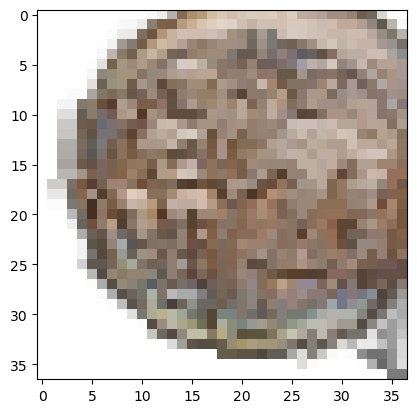

MatchingPatches(left=torch.Size([37, 37, 384]), right=torch.Size([37, 37, 384]), corr_lr=torch.Size([42, 2]), corr_rl=torch.Size([1113, 2]))

In [230]:
mp = match_patches(image1, image2, pair.H)
mp

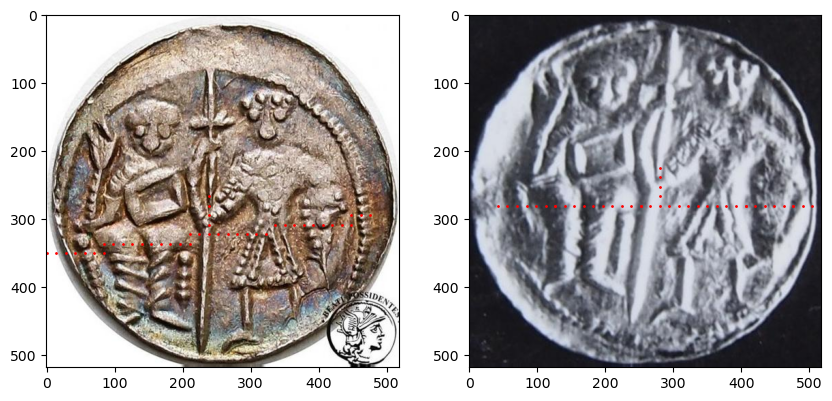

In [231]:
lxs, lys = np.unravel_index(mp.corr_lr[:, 1].cpu().numpy(), (37, 37))
rxs, rys = np.unravel_index(mp.corr_lr[:, 0].cpu().numpy(), (37, 37))

fig, (a1, a2) = plt.subplots(1, 2, figsize=(10, 5))
a1.imshow(image1)
a1.scatter(lys * 14, lxs * 14, c='r', s=1)
#a1.scatter(lxs * 14, lys * 14, c='r', s=1)
a2.imshow(image2)
a2.scatter(rys * 14, rxs * 14, c='r', s=1)
#a2.scatter(rxs * 14, rys * 14, c='r', s=1)

In [232]:
print(mp.corr_lr[:5])
print(mp.corr_lr[-5:])

tensor([[743, 925],
        [744, 926],
        [745, 927],
        [746, 928],
        [747, 929]])
tensor([[773, 845],
        [774, 809],
        [774, 846],
        [775, 810],
        [776, 811]])


In [233]:
37*37

1369

In [234]:
mp.corr_lr[..., 0].max()

tensor(776)

In [235]:
from tqdm.auto import tqdm

device = torch.device('mps')
embedder = nn.Linear(384, 32).to(device)
mp = mp.to(device)
optim = torch.optim.Adam(embedder.parameters(), lr=1e-3)

with tqdm(range(10)) as pbar:
    for i in pbar:
        optim.zero_grad()
        loss = mp.loss(embedder)
        loss.backward()
        optim.step()
        pbar.set_postfix(loss=loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

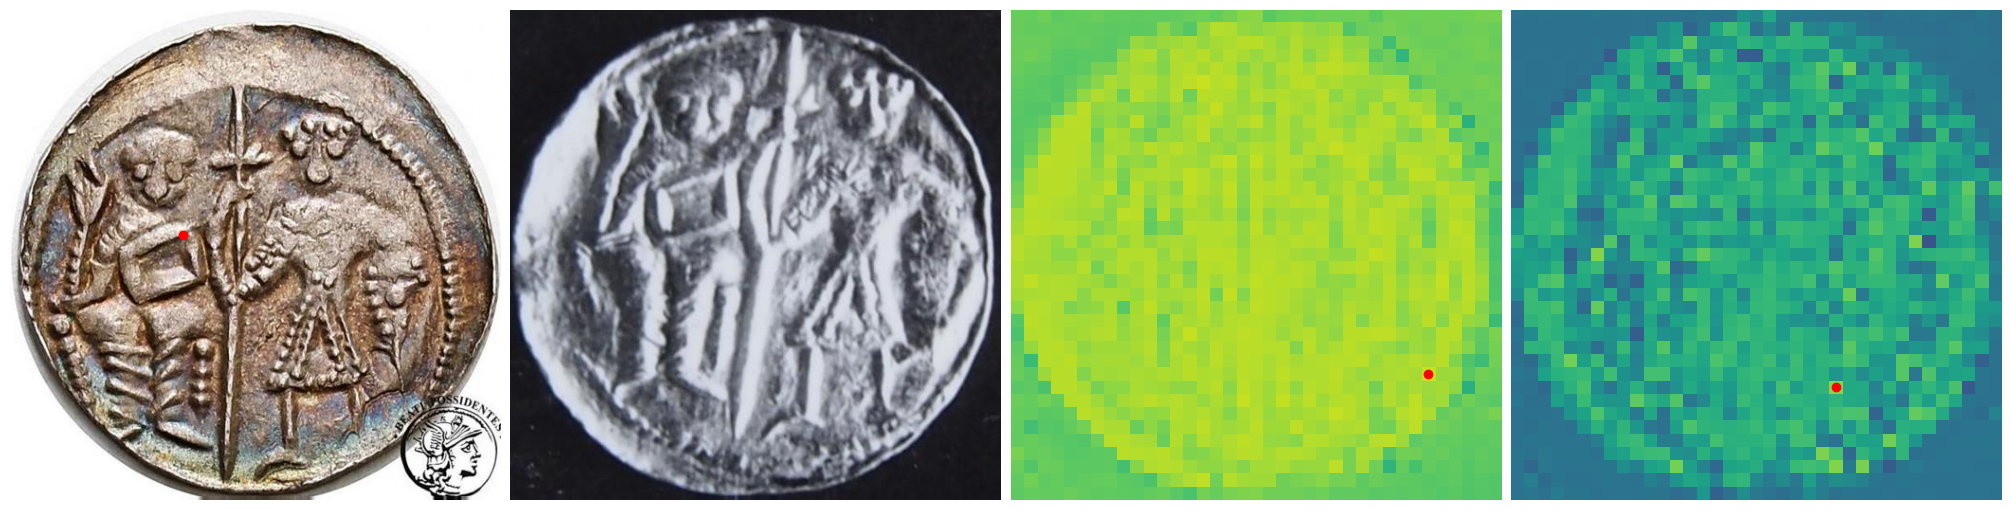

In [236]:
point = 13, 17
fig, (a1, a2, a3, a4) = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)
a1.imshow(image1)
a1.scatter([point[0] * 14], [point[1] * 14], c='r')
a2.imshow(image2)
similarity_base = F.cosine_similarity(mp.left[point[1], point[0]], mp.right, dim=-1)
argmax_x, argmax_y = np.unravel_index(similarity_base.argmax().cpu().numpy(), similarity_base.shape)
a3.imshow(similarity_base.cpu().numpy().reshape(37, 37), vmin=-1, vmax=1)
a3.scatter([argmax_y], [argmax_x], c='r')
with torch.no_grad():
    similarity_embedder = F.cosine_similarity(embedder(mp.left)[point[1], point[0]], embedder(mp.right), dim=-1)
similarity_embedder = similarity_embedder.cpu().numpy().reshape(37, 37)
argmax_x, argmax_y = np.unravel_index(similarity_embedder.argmax(), similarity_embedder.shape)
a4.imshow(similarity_embedder, vmin=-1, vmax=1)
a4.scatter([argmax_y], [argmax_x], c='r')

for ax in (a1, a2, a3, a4):
    ax.axis('off')